In [1]:
import requests
import os
from dotenv import load_dotenv
from langchain_community.llms import Ollama
from langchain_community.chat_models import ChatOllama

In [1]:
WEATHER_API_URL = "http://api.weatherapi.com/v1/forecast.json"
WEATHER_API_KEY = "887f15bff1d34781807164205250403"

In [3]:
def get_weather_data(location):
    params = {
        "key": WEATHER_API_KEY,
        "q": location,
        "days": 7,
        "aqi":"no",
        "alerts":"no"
    }
    response = requests.get(WEATHER_API_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        forecast = data["forecast"]["forecastday"]
        avg_temp = sum([day['day']['avgtemp_c'] for day in forecast]) / len(forecast)
        total_rainfall = sum([day['day']['totalprecip_mm'] for day in forecast])
        avg_humidity = sum([day['day']['avghumidity'] for day in forecast]) / len(forecast)
        return {
            'avg_temp':round(avg_temp,2),
            'total_rainfall': round(total_rainfall,2),
            'avg_humidity': round(avg_humidity,2),
            'forecast': forecast
        }
    else:
        return None

* Example of the response

* {
    "forecast": {
        "forecastday": [
            {
                "date": "2024-03-01",
                "day": {
                    "avgtemp_c": 22.5,
                    "totalprecip_mm": 5.6,
                    "avghumidity": 65
                }
            },
            {
                "date": "2024-03-02",
                "day": {
                    "avgtemp_c": 21.8,
                    "totalprecip_mm": 3.2,
                    "avghumidity": 70
                }
            }
        ]
    }
}


In [ ]:
import pandas as pd
import numpy as np
local_data = pd.read_csv('seasonal_crop_recommendation_data.csv')

def get_local_crop_data(region, crop, soil_type):
    
    filtered_data = local_data[
        (local_data["Region"] == region) &
        (local_data["Crop Planted"] == crop) &
        (local_data["Soil Type"] == soil_type)
    ]

    if not filtered_data.empty:
        return filtered_data.iloc[0].to_dict()  # Convert to dictionary
    return None

In [11]:
from langchain_community.chat_models import ChatOllama

def generate_recommendation(region, crop, planting_period, location, soil_type=None):
    print(f"Generating recommendation for {crop} in {region}...")

    # Fetch local crop data
    crop_info = get_local_crop_data(region, crop, soil_type)
    weather_summary = get_weather_data(location)

    if not weather_summary:
        return "Error fetching weather data. Please check your location."
    
    if not crop_info:
        return "Crop data not found in the dataset."

    # Extract relevant information
    optimal_temp = crop_info.get('Temperature (°C)', 'N/A')
    rainfall_range = crop_info.get('Rainfall (mm)', 'N/A')
    maturation_period = crop_info.get('Maturation Period (Days)', 'N/A')
    market_demand = crop_info.get('Market Demand (Price/kg)', 'N/A')
    historical_yield = crop_info.get('Historical Yield (kg/ha)', 'N/A')
    irrigation_avail = crop_info.get('Irrigation Availability', 'N/A')
    pest_risk = crop_info.get('Pests/Disease Risk', 'N/A')

    # Create recommendation prompt
    prompt = f"""
    You are an AI assistant designed to help farmers make better planting decisions.
    
    **Crop Selection:** {crop}
    **Region:** {region}
    **Location:** {location}
    **Soil Type:** {soil_type if soil_type else "Not specified"}
    **Planting Period:** {planting_period}
    
    **Crop Data:**
    - Optimal Temperature: {optimal_temp}
    - Rainfall Range: {rainfall_range}
    - Maturation Period: {maturation_period}
    - Market Demand: {market_demand}
    - Historical Yield: {historical_yield}
    - Irrigation Availability: {irrigation_avail}
    - Pests/Disease Risk: {pest_risk}

    **Task:**  
    Analyze the given conditions and provide a recommendation on whether this planting period is optimal.  
    Suggest possible adjustments, if necessary.
    """

    # Initialize ChatOllama correctly
    chat_model = ChatOllama(model="gemma2:2b")  # Use correct model name
    response = chat_model.invoke(prompt)  # Use invoke() to get response

    return response

In [13]:
result = generate_recommendation("North-West", "Sorghum", "June-Aug", "Kano", "Loamy")

Generating recommendation for Sorghum in North-West...


In [16]:
print(result.content)

## Sorghum Planting in Kano - Analysis & Recommendations 

Based on the provided information, we can analyze the suitability of planting sorghum in Kano during June-August:

**Positive Factors:**

* **Optimal Temperature:** The crop's optimal temperature of 32.5°C aligns well with typical summer conditions in Kano. This suggests good growth potential.
* **Historical Yield:** A historical yield of 3537 tons per hectare indicates the region's potential for successful sorghum cultivation. This provides a strong baseline for comparison and optimism.
* **Market Demand:**  A market demand of 319 units per hectare showcases potential for selling your harvest. This suggests an active market, but further research is needed to analyze specific buyer profiles and demands within the region.
* **Irrigation Availability:** The availability of irrigation resources ensures consistent water supply throughout the planting period, crucial for successful sorghum cultivation in the North-West region's gene

##### 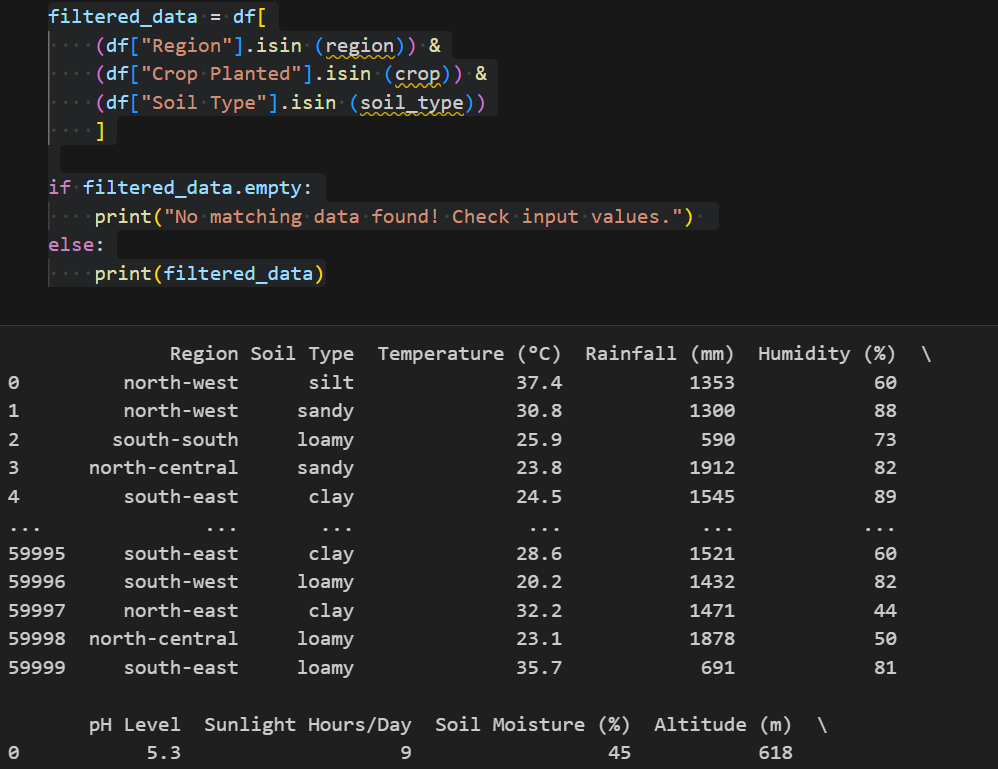